In [3]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [17]:
yf.pdr_override()
df = pdr.get_data_yahoo("ETH=F", start="2022-01-01", end="2023-03-20")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [18]:
df.to_csv("Price_ETH.csv")

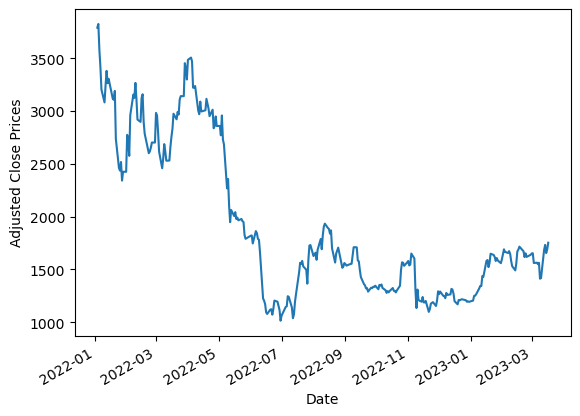

In [19]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [20]:
df.dropna(inplace=True)

In [21]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(304,)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [23]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 1, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12, 'bootstrap': False}


In [25]:
model = RandomForestRegressor(n_estimators=1000, random_state=30, min_samples_split=2, min_samples_leaf=1, max_depth=9, bootstrap=False)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[3225.7955     1842.4585     1208.01975    1579.75       1637.891
 1564.29975    2858.29966406 1579.75       1204.5        1708.5025
 1292.8205     1192.9585     1928.84       1320.5        1963.9925
 2424.57006836 1204.5        3448.624      3221.4455     2551.5
 1209.75       1344.1861676  3120.393      1197.808      1579.75
 1980.2405     2964.00325    1688.7375     1249.         1589.791
 1272.6875     3446.6195     1566.5        2964.00325    2302.566
 1280.51       3226.852      1560.25       1563.25       1160.552
 1258.03       1344.95286755 1581.24759766 1823.531      3093.081
 2163.825      1552.5        1325.256      2625.4425     1160.7035
 1254.932      2712.27572729 1271.8395     3448.2305     2688.28876782
 1188.3641311  1649.         1126.4815     1308.616      3448.624
 1325.668      1495.605      3242.         3097.245      1788.595
 1919.344      1788.385      1420.54       1619.1155     1271.8395
 1265.         2909.8815     2003.9625     2761.46       2626.667
 129

In [26]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 9.0833
Mean Squared Error: 268.2227
Root Mean Squared Error: 16.3775
(R^2) Score: 0.9995
Train Score : 100.00% and Test Score : 99.95% using Random Tree Regressor.
Accuracy: 99.6 %.


In [27]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
    Unnamed: 0  Predictions
11  2023-03-28    1192.9585
11    1192.9585
Name: Predictions, dtype: float64
Sell price and date
17    3448.624
Name: Predictions, dtype: float64


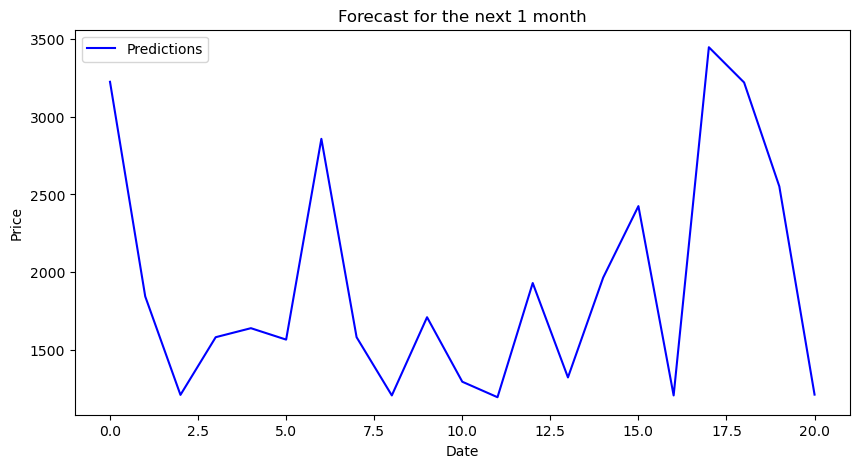

In [28]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 1 month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()